In [1]:
import numpy
import cvxopt
from cvxopt import matrix

In [2]:
from cvxopt import matrix, mul, div, cos, sin, exp, sqrt
from cvxopt import blas, lapack, solvers
try: import pylab
except ImportError: pylab_installed = False
else: pylab_installed = True

In [3]:
# Signal.


NameError: name 'ts' is not defined

In [ ]:
# Basis pursuit problem
#
#     minimize    ||A*x - y||_2^2 + ||x||_1
#
#     minimize    x'*A'*A*x - 2.0*y'*A*x + 1'*u
#     subject to  -u <= x <= u
#
# Variables x (n),  u (n).

m, n = A.size
r = matrix(0.0, (m,1))

q = matrix(1.0, (2*n,1))
blas.gemv(A, y, q, alpha = -2.0, trans = 'T')

In [ ]:
def P(u, v, alpha = 1.0, beta = 0.0):
    """
    Function and gradient evaluation of

        v := alpha * 2*A'*A * u + beta * v
    """

    blas.gemv(A, u, r)
    blas.gemv(A, r, v, alpha = 2.0*alpha, beta = beta, trans = 'T')

In [ ]:
def G(u, v, alpha = 1.0, beta = 0.0, trans = 'N'):
    """
        v := alpha*[I, -I; -I, -I] * u + beta * v  (trans = 'N' or 'T')
    """

    blas.scal(beta, v)
    blas.axpy(u, v, n = n, alpha = alpha)
    blas.axpy(u, v, n = n, alpha = -alpha, offsetx = n)
    blas.axpy(u, v, n = n, alpha = -alpha, offsety = n)
    blas.axpy(u, v, n = n, alpha = -alpha, offsetx = n, offsety = n)

In [ ]:
h = matrix(0.0, (2*n,1))

In [ ]:
# Customized solver for the KKT system
#
#     [  2.0*A'*A   0    I      -I     ] [x[:n] ]     [bx[:n] ]
#     [  0          0   -I      -I     ] [x[n:] ]  =  [bx[n:] ].
#     [  I         -I   -D1^-1   0     ] [z[:n] ]     [bz[:n] ]
#     [ -I         -I    0      -D2^-1 ] [z[n:] ]     [bz[n:] ]
#
# where D1 = W['di'][:n]**2,  D2 = W['di'][:n]**2.
#
# We first eliminate z and x[n:]:
#
#     ( 2*A'*A + 4*D1*D2*(D1+D2)^-1 ) * x[:n] =
#         bx[:n] - (D2-D1)*(D1+D2)^-1 * bx[n:]
#         + D1 * ( I + (D2-D1)*(D1+D2)^-1 ) * bz[:n]
#         - D2 * ( I - (D2-D1)*(D1+D2)^-1 ) * bz[n:]
#
#     x[n:] = (D1+D2)^-1 * ( bx[n:] - D1*bz[:n]  - D2*bz[n:] )
#              - (D2-D1)*(D1+D2)^-1 * x[:n]
#
#     z[:n] = D1 * ( x[:n] - x[n:] - bz[:n] )
#     z[n:] = D2 * (-x[:n] - x[n:] - bz[n:] ).
#
#
# The first equation has the form
#
#     (A'*A + D)*x[:n]  =  rhs
#
# and is equivalent to
#
#     [ D    A' ] [ x:n] ]  = [ rhs ]
#     [ A   -I  ] [ v    ]    [ 0   ].
#
# It can be solved as
#
#     ( A*D^-1*A' + I ) * v = A * D^-1 * rhs
#     x[:n] = D^-1 * ( rhs - A'*v ).

In [ ]:
S = matrix(0.0, (m,m))
Asc = matrix(0.0, (m,n))
v = matrix(0.0, (m,1))

In [4]:
def Fkkt(W):

    # Factor
    #
    #     S = A*D^-1*A' + I
    #
    # where D = 2*D1*D2*(D1+D2)^-1, D1 = d[:n]**2, D2 = d[n:]**2.

    d1, d2 = W['di'][:n]**2, W['di'][n:]**2

    # ds is square root of diagonal of D
    ds = sqrt(2.0) * div( mul( W['di'][:n], W['di'][n:]), sqrt(d1+d2) )
    d3 =  div(d2 - d1, d1 + d2)

    # Asc = A*diag(d)^-1/2
    blas.copy(A, Asc)
    for k in range(m):
        blas.tbsv(ds, Asc, n=n, k=0, ldA=1, incx=m, offsetx=k)

    # S = I + A * D^-1 * A'
    blas.syrk(Asc, S)
    S[::m+1] += 1.0
    lapack.potrf(S)

    def g(x, y, z):

        x[:n] = 0.5 * ( x[:n] - mul(d3, x[n:]) + \
                mul(d1, z[:n] + mul(d3, z[:n])) - \
                mul(d2, z[n:] - mul(d3, z[n:])) )
        x[:n] = div( x[:n], ds)

        # Solve
        #
        #     S * v = 0.5 * A * D^-1 * ( bx[:n]
        #             - (D2-D1)*(D1+D2)^-1 * bx[n:]
        #             + D1 * ( I + (D2-D1)*(D1+D2)^-1 ) * bz[:n]
        #             - D2 * ( I - (D2-D1)*(D1+D2)^-1 ) * bz[n:] )

        blas.gemv(Asc, x, v)
        lapack.potrs(S, v)

        # x[:n] = D^-1 * ( rhs - A'*v ).
        blas.gemv(Asc, v, x, alpha=-1.0, beta=1.0, trans='T')
        x[:n] = div(x[:n], ds)

        # x[n:] = (D1+D2)^-1 * ( bx[n:] - D1*bz[:n]  - D2*bz[n:] )
        #         - (D2-D1)*(D1+D2)^-1 * x[:n]
        x[n:] = div( x[n:] - mul(d1, z[:n]) - mul(d2, z[n:]), d1+d2 )\
                - mul( d3, x[:n] )

        # z[:n] = D1^1/2 * (  x[:n] - x[n:] - bz[:n] )
        # z[n:] = D2^1/2 * ( -x[:n] - x[n:] - bz[n:] ).
        z[:n] = mul( W['di'][:n],  x[:n] - x[n:] - z[:n] )
        z[n:] = mul( W['di'][n:], -x[:n] - x[n:] - z[n:] )

    return g

In [5]:
x = solvers.coneqp(P, q, G, h, kktsolver = Fkkt)['x'][:n]

I = [ k for k in range(n) if abs(x[k]) > 1e-2 ]
xls = +y
lapack.gels(A[:,I], xls)
ybp = A[:,I]*xls[:len(I)]

print("Sparse basis contains %d basis functions." %len(I))
print("Relative RMS error = %.1e." %(blas.nrm2(ybp-y) / blas.nrm2(y)))

NameError: name 'P' is not defined

NameError: name 'ts' is not defined

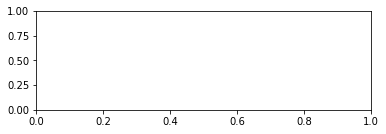

In [6]:
if pylab_installed:
    pylab.figure(2, facecolor='w')
    pylab.subplot(211)
    pylab.plot(ts, y, '-', ts, ybp, 'r--')
    pylab.xlabel('t')
    pylab.ylabel('y(t), yhat(t)')
    pylab.axis([0, 1, -1.5, 1.5])
    pylab.title('Signal and basis pursuit approximation (fig. 6.22)')
    pylab.subplot(212)
    pylab.plot(ts, y-ybp, '-')
    pylab.xlabel('t')
    pylab.ylabel('y(t)-yhat(t)')
    pylab.axis([0, 1, -0.05, 0.05])

    pylab.figure(3, facecolor='w')
    pylab.subplot(211)
    pylab.plot(ts, y, '-')
    pylab.xlabel('t')
    pylab.ylabel('y(t)')
    pylab.axis([0, 1, -1.5, 1.5])
    pylab.title('Signal and time-frequency plot (fig. 6.23)')
    pylab.subplot(212)
    omegas, taus = [], []
    for i in I:
        if i < K:
            omegas += [0.0]
            taus += [i*tau]
        else:
            l = (i-K)/(2*K)+1
            k = ((i-K)%(2*K)) %K
            omegas += [l*omega0]
            taus += [k*tau]
    pylab.plot(ts, 150*abs(cos(5.0*ts)), '-', taus, omegas, 'ro')
    pylab.xlabel('t')
    pylab.ylabel('omega(t)')
    pylab.axis([0, 1, -5, 155])
    pylab.show()